In [1]:
import os
import medusa
from pickle import load
import pandas as pd
import json
import numpy

import matplotlib.pyplot as plt
import matplotlib

from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import KMeans

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.manifold import MDS

from skbio.stats.ordination import pcoa
from skbio.stats.distance import DissimilarityMatrix

In [2]:
# load the gene knockout dataframes
gene_knockout_results = {}    
for fname in os.listdir('../results/gene_knockouts/'):
    species = fname.split('.')[0]
    gene_knockout_results[species] = pd.read_csv(
        '../results/gene_knockouts/'+species+'.csv',sep=',',index_col=0)

In [3]:
# load the ensembles, which we will need later.
# load all ensembles
ensembles = {}
exclude = ['Bacillus megaterium','Stenotrophomonas maltophilia']
for species_file in os.listdir("../results/deep_ensembles/"):
    species_name = species_file.split(".")[0]
    
    if species_name not in exclude:
        with open("../results/deep_ensembles/"+species_name+".pickle",'rb') as infile:
            ensembles[species_name] = load(infile)

In [4]:
# Get the ensemble feature states for each species, which will be used as input
# to regression with principle coordinates as output.
feature_frames = {}
for species in ensembles.keys():
    ensemble = ensembles[species]
    # Grab the features and states for the ensemble and convert to a dataframe
    feature_dict = {}
    for feature in ensemble.features:
        feature_dict[feature.id] = feature.states
    feature_frame = pd.DataFrame.from_dict(feature_dict)

    # Convert to a boolean dataframe for faster computation
    # (0 values become False, all others become True (i.e. active features))
    feature_frames[species] = feature_frame.astype(bool)

/home/greg/Envs/ssl_ensembles/lib/python3.5/site-packages/matplotlib/pyplot.py:522 RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


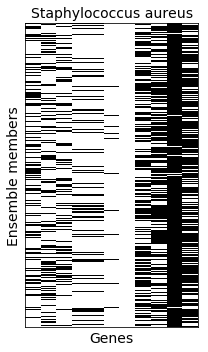

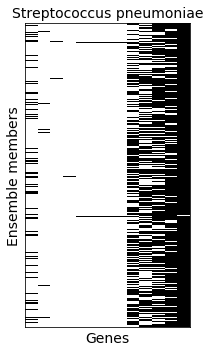

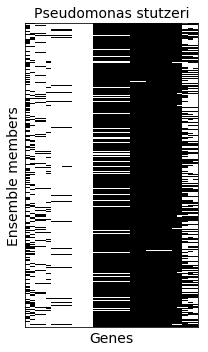

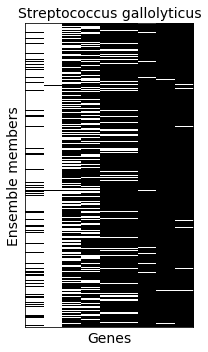

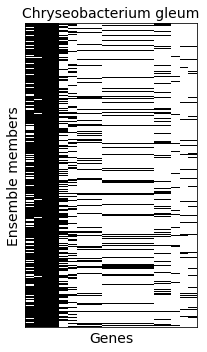

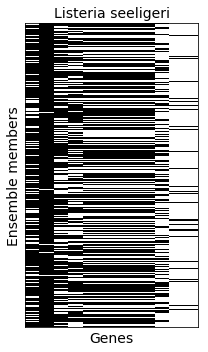

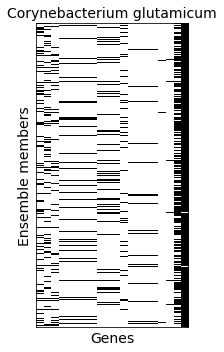

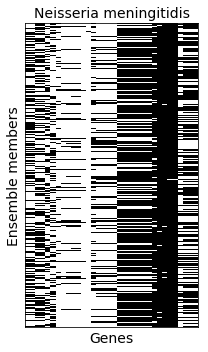

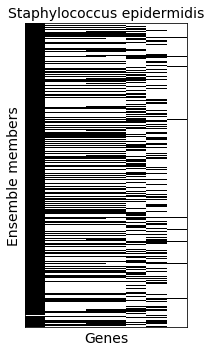

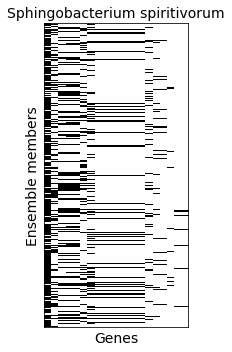

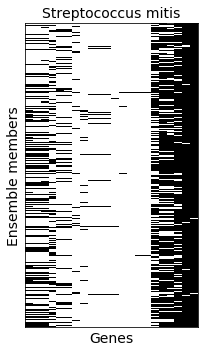

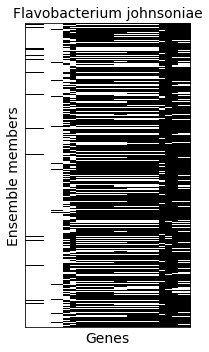

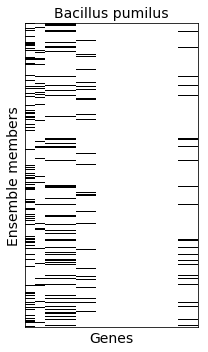

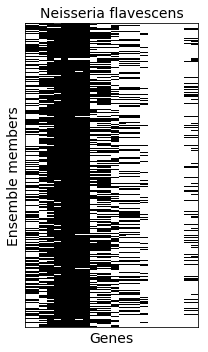

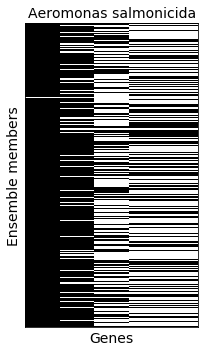

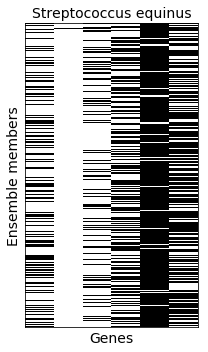

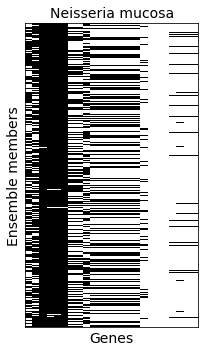

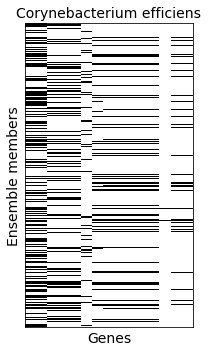

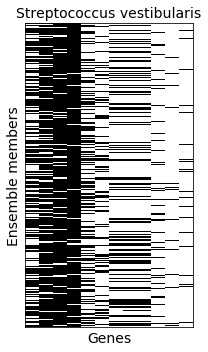

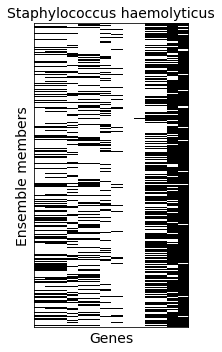

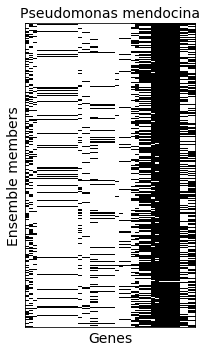

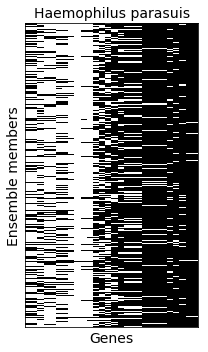

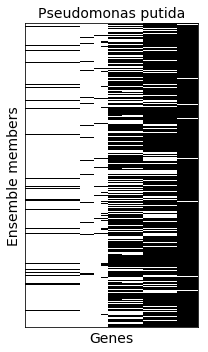

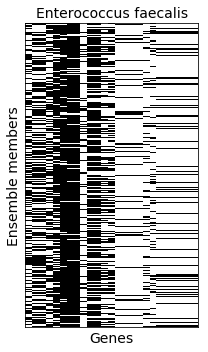

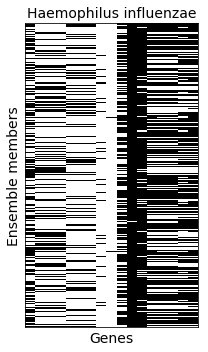

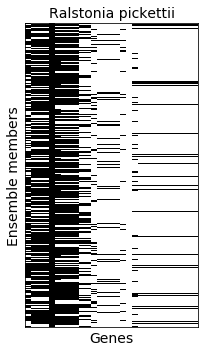

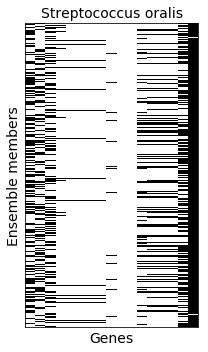

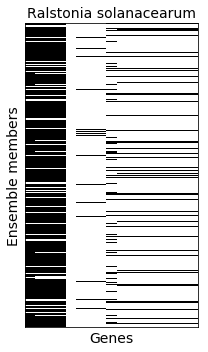

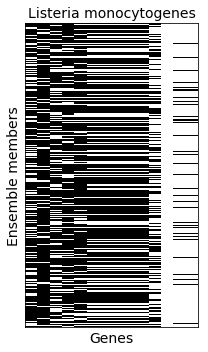

In [5]:
essentiality_ax = {}
for species in gene_knockout_results.keys():
    if species not in exclude:
        if len(gene_knockout_results[species].keys()) > 200: # REMOVE THIS AFTER WE'VE FULLY CONVERTED TO DEEP ENSEMBLES
            # for this species, create a dataframe that has genes that never had an effect
            # on growth removed for visualization
            plotframe = gene_knockout_results[species]


            # normalize each ensemble's knockout results by dividing by it's max growth rate
            #plotframe = plotframe.div(plotframe.max(axis=0), axis=1)

            # binarize the data

            #plotframe = plotframe.loc[(plotframe > 1E-8).sum(axis=1) < len(plotframe.columns)]
            # Also remove reactions that were essential in all members
            #plotframe = plotframe.loc[(plotframe < 1E-8).sum(axis=1) != len(plotframe.columns)]

            plotframe = plotframe > 1E-6
            plotframe = plotframe.loc[(plotframe == 0).sum(axis=1) != len(plotframe.columns)]
            plotframe = plotframe.loc[(plotframe == 1).sum(axis=1) < len(plotframe.columns)]
            plotvals = plotframe.values

            # reorder by heirarchical clustering of genes
            dgram = dendrogram(linkage(pdist(plotvals,metric='hamming')),labels=plotframe.index,no_plot=True)
            plotframe = plotframe.reindex(dgram['ivl'])
            plotvals = plotframe.values

            #plotvals = plotvals/plotvals.max()
            rxn_labels = plotframe.index

            # Black cells are non-essential, white cells are essential.
            fig, ax = plt.subplots()
            im = ax.imshow(plotvals.T,cmap='binary')
            ax.set_ylabel('Ensemble members',size=14)
            ax.set_xlabel('Genes',size=14)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title(species,size=14)
            ax.set_aspect('auto')
            fig.set_size_inches(3,5)
            fig.tight_layout()
            essentiality_ax[species] = ax
            fig.savefig('../results/gene_knockout_plots/'+species+'_gene_knockouts.png')
            fig.savefig('../results/gene_knockout_plots/'+species+'_gene_knockouts.svg')

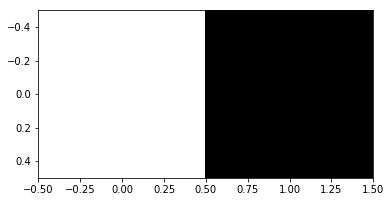

In [6]:
# Sanity check: True values are black, False values are white.
fig,ax=plt.subplots()
ax.imshow([[False,True]],cmap='binary')

/home/greg/Envs/ssl_ensembles/lib/python3.5/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152 RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -4.3547600824279975 and the largest is 27.415615693029142.


For Staphylococcus aureus:
# of members in cluster 0: 779
# of members in cluster 1: 221


/home/greg/Envs/ssl_ensembles/lib/python3.5/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152 RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -1.8243338436377463 and the largest is 7.77938465514921.


For Streptococcus pneumoniae:
# of members in cluster 0: 450
# of members in cluster 1: 547


/home/greg/Envs/ssl_ensembles/lib/python3.5/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152 RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -1.548379091364696 and the largest is 11.95289523988964.


For Pseudomonas stutzeri:
# of members in cluster 0: 128
# of members in cluster 1: 869


/home/greg/Envs/ssl_ensembles/lib/python3.5/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152 RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -4.207940768414332 and the largest is 15.11371207084758.


For Streptococcus gallolyticus:
# of members in cluster 0: 666
# of members in cluster 1: 328


/home/greg/Envs/ssl_ensembles/lib/python3.5/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152 RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -6.285234189394356 and the largest is 30.116967140776364.


For Chryseobacterium gleum:
# of members in cluster 0: 814
# of members in cluster 1: 176


/home/greg/Envs/ssl_ensembles/lib/python3.5/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152 RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -10.529336437205387 and the largest is 86.76647102471011.


For Listeria seeligeri:
# of members in cluster 0: 604
# of members in cluster 1: 386


/home/greg/Envs/ssl_ensembles/lib/python3.5/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152 RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -2.9455330173046805 and the largest is 15.96566208685442.


For Corynebacterium glutamicum:
# of members in cluster 0: 866
# of members in cluster 1: 115


/home/greg/Envs/ssl_ensembles/lib/python3.5/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152 RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -7.7455926596590965 and the largest is 45.25659675655889.


For Neisseria meningitidis:
# of members in cluster 0: 722
# of members in cluster 1: 264


/home/greg/Envs/ssl_ensembles/lib/python3.5/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152 RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -14.931238823572073 and the largest is 85.75264545100295.


For Staphylococcus epidermidis:
# of members in cluster 0: 512
# of members in cluster 1: 487


/home/greg/Envs/ssl_ensembles/lib/python3.5/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152 RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -7.3818876528414545 and the largest is 33.413393450187804.


For Sphingobacterium spiritivorum:
# of members in cluster 0: 861
# of members in cluster 1: 137


/home/greg/Envs/ssl_ensembles/lib/python3.5/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152 RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -2.2644734404564746 and the largest is 15.888265995629864.


For Streptococcus mitis:
# of members in cluster 0: 640
# of members in cluster 1: 356


/home/greg/Envs/ssl_ensembles/lib/python3.5/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152 RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -5.463892628086205 and the largest is 65.92194851373168.


For Flavobacterium johnsoniae:
# of members in cluster 0: 653
# of members in cluster 1: 346


/home/greg/Envs/ssl_ensembles/lib/python3.5/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152 RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -1.8973366453677656 and the largest is 12.623959123376107.


For Bacillus pumilus:
# of members in cluster 0: 738
# of members in cluster 1: 181


/home/greg/Envs/ssl_ensembles/lib/python3.5/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152 RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -3.6462792146495375 and the largest is 20.375681332119406.


For Neisseria flavescens:
# of members in cluster 0: 721
# of members in cluster 1: 279


/home/greg/Envs/ssl_ensembles/lib/python3.5/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152 RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -14.72984156825758 and the largest is 54.81159890111044.


For Aeromonas salmonicida:
# of members in cluster 0: 456
# of members in cluster 1: 324


/home/greg/Envs/ssl_ensembles/lib/python3.5/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152 RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -8.104467701363683 and the largest is 35.04819502278237.


For Streptococcus equinus:
# of members in cluster 0: 568
# of members in cluster 1: 424


/home/greg/Envs/ssl_ensembles/lib/python3.5/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152 RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -5.796701546934623 and the largest is 39.569391701129696.


For Neisseria mucosa:
# of members in cluster 0: 369
# of members in cluster 1: 607


/home/greg/Envs/ssl_ensembles/lib/python3.5/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152 RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -9.815134612437296 and the largest is 42.623713238639.


For Corynebacterium efficiens:
# of members in cluster 0: 670
# of members in cluster 1: 143


/home/greg/Envs/ssl_ensembles/lib/python3.5/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152 RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -5.51440608124002 and the largest is 37.77280083586663.


For Streptococcus vestibularis:
# of members in cluster 0: 672
# of members in cluster 1: 327


/home/greg/Envs/ssl_ensembles/lib/python3.5/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152 RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -7.34092337442413 and the largest is 32.24206535510713.


For Staphylococcus haemolyticus:
# of members in cluster 0: 623
# of members in cluster 1: 375


/home/greg/Envs/ssl_ensembles/lib/python3.5/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152 RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -1.8183413449451808 and the largest is 13.641598285622115.
/home/greg/Envs/ssl_ensembles/lib/python3.5/site-packages/matplotlib/pyplot.py:522 RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


For Pseudomonas mendocina:
# of members in cluster 0: 883
# of members in cluster 1: 97


/home/greg/Envs/ssl_ensembles/lib/python3.5/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152 RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -2.3615521898241014 and the largest is 15.848073632130234.
/home/greg/Envs/ssl_ensembles/lib/python3.5/site-packages/matplotlib/pyplot.py:522 RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


For Haemophilus parasuis:
# of members in cluster 0: 389
# of members in cluster 1: 610


/home/greg/Envs/ssl_ensembles/lib/python3.5/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152 RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -5.680862242958173 and the largest is 22.618410283829398.
/home/greg/Envs/ssl_ensembles/lib/python3.5/site-packages/matplotlib/pyplot.py:522 RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


For Pseudomonas putida:
# of members in cluster 0: 540
# of members in cluster 1: 326


/home/greg/Envs/ssl_ensembles/lib/python3.5/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152 RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -5.255612504736073 and the largest is 38.049937300363794.
/home/greg/Envs/ssl_ensembles/lib/python3.5/site-packages/matplotlib/pyplot.py:522 RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


For Enterococcus faecalis:
# of members in cluster 0: 793
# of members in cluster 1: 205


/home/greg/Envs/ssl_ensembles/lib/python3.5/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152 RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -15.295571726791861 and the largest is 65.59302306615145.
/home/greg/Envs/ssl_ensembles/lib/python3.5/site-packages/matplotlib/pyplot.py:522 RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


For Haemophilus influenzae:
# of members in cluster 0: 660
# of members in cluster 1: 320


/home/greg/Envs/ssl_ensembles/lib/python3.5/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152 RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -3.5199797604141447 and the largest is 26.69722308905711.
/home/greg/Envs/ssl_ensembles/lib/python3.5/site-packages/matplotlib/pyplot.py:522 RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


For Ralstonia pickettii:
# of members in cluster 0: 94
# of members in cluster 1: 872


/home/greg/Envs/ssl_ensembles/lib/python3.5/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152 RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -2.841575530398754 and the largest is 26.66511419891919.
/home/greg/Envs/ssl_ensembles/lib/python3.5/site-packages/matplotlib/pyplot.py:522 RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


For Streptococcus oralis:
# of members in cluster 0: 753
# of members in cluster 1: 234


/home/greg/Envs/ssl_ensembles/lib/python3.5/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152 RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -3.5534362533115855 and the largest is 50.512708987837165.
/home/greg/Envs/ssl_ensembles/lib/python3.5/site-packages/matplotlib/pyplot.py:522 RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


For Ralstonia solanacearum:
# of members in cluster 0: 831
# of members in cluster 1: 160


/home/greg/Envs/ssl_ensembles/lib/python3.5/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152 RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -9.606330614698182 and the largest is 73.12798756679274.
/home/greg/Envs/ssl_ensembles/lib/python3.5/site-packages/matplotlib/pyplot.py:522 RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


For Listeria monocytogenes:
# of members in cluster 0: 659
# of members in cluster 1: 340


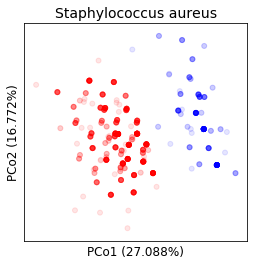

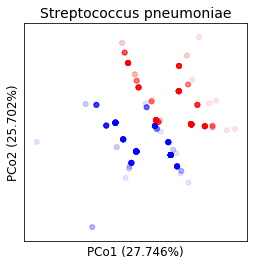

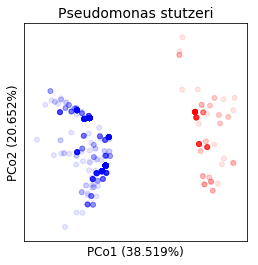

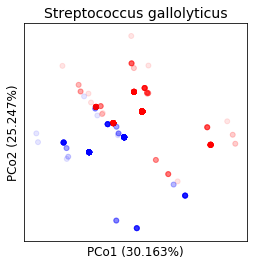

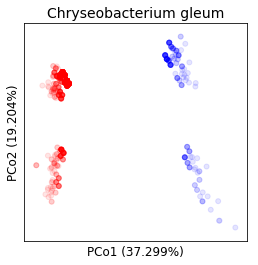

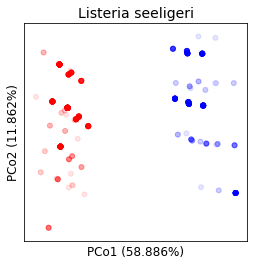

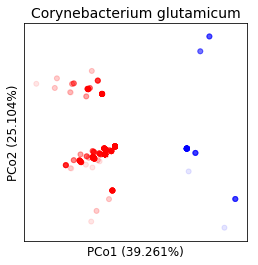

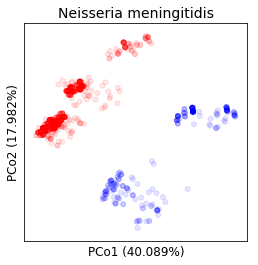

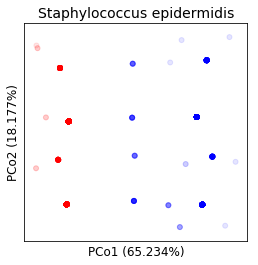

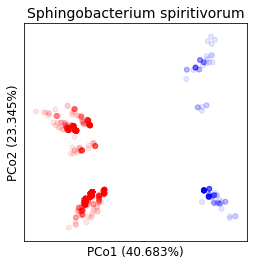

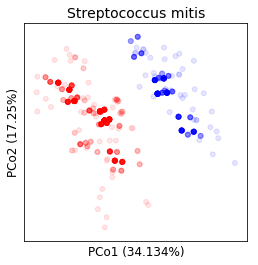

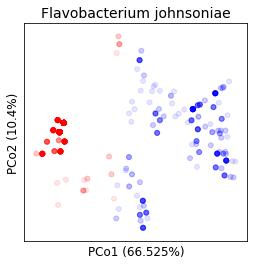

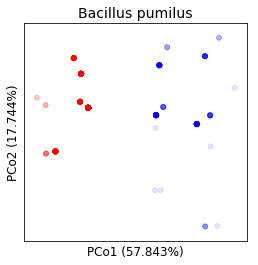

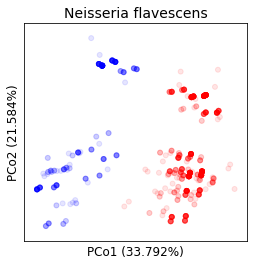

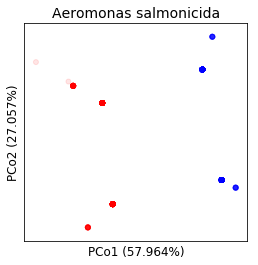

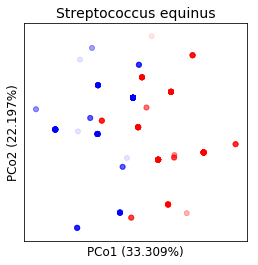

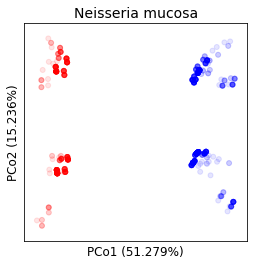

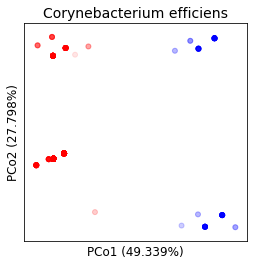

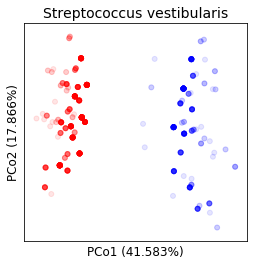

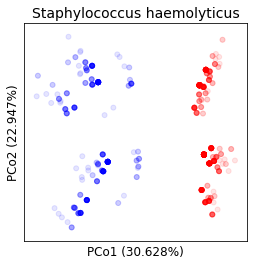

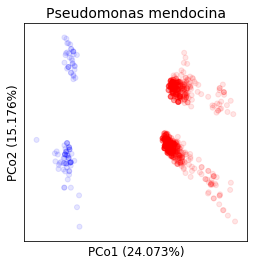

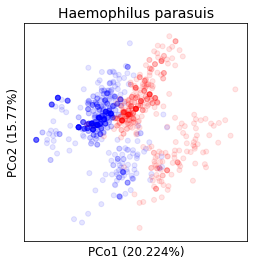

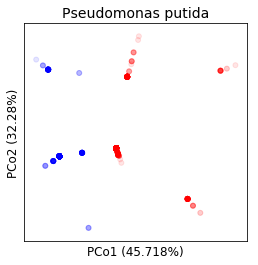

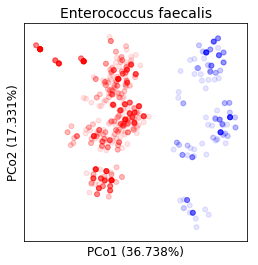

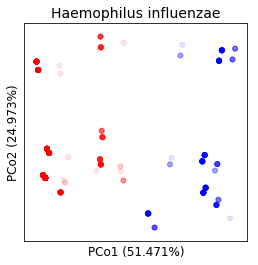

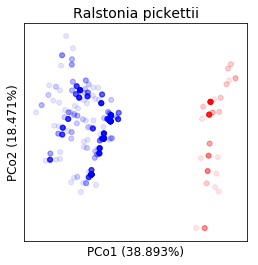

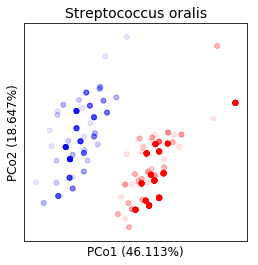

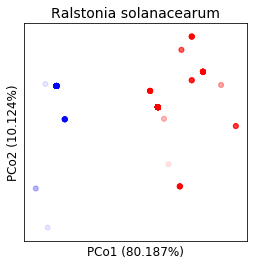

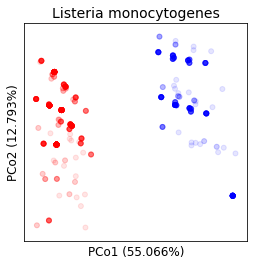

In [7]:
# Calculate the gene knockout distance between ensemble members, perform PCA on the distance
# matrix, then regress on PC1.
pipe_w_scale = make_pipeline(StandardScaler(), PCA(n_components=2))
classifiers = {}
classifier_scores = {}
pcoa_ax = {}
for species in gene_knockout_results.keys():
    if species not in ["Stenotrophomonas maltophilia"]:
        if len(gene_knockout_results[species].keys()) > 200: # REMOVE AFTER CONVERTING TO DEEP ENSEMBLES
            df_for_pca = gene_knockout_results[species]

            df_for_pca = df_for_pca > 1E-6
            df_for_pca = df_for_pca.loc[(df_for_pca == False).sum(axis=1) != len(df_for_pca.columns)]
            df_for_pca = df_for_pca.loc[(df_for_pca == True).sum(axis=1) < len(df_for_pca.columns)]
            df_for_pca = df_for_pca.T

            # perform kmeans clustering on the gene profiles to determine
            # the two clusters with maximal variance
            clust = KMeans(n_clusters = 2).fit(df_for_pca.values)
            
            pca_input = DissimilarityMatrix(squareform(pdist(df_for_pca,metric="hamming")),ids=df_for_pca.index)
            pcoa_result = pcoa(pca_input, number_of_dimensions=3)

            # Add scores for each sample back to the dataframes
            df_for_pca['PCo1'] = pcoa_result.samples['PC1'].values#mds_coords[:,0]#pc1
            df_for_pca['PCo2'] = pcoa_result.samples['PC2'].values#mds_coords[:,1]#pc2
            df_for_pca['cluster'] = clust.labels_

            # grab the ensembles feature frame, fit the classifier
            feature_frame = feature_frames[species]
            input_cols = feature_frame.columns
            df_for_pca = df_for_pca.merge(feature_frame,left_index=True,right_index=True)
            # perform regression using random forest
            classifiers[species] = RandomForestClassifier(n_estimators=500, oob_score=True).fit(
                df_for_pca[input_cols],df_for_pca['cluster'])


            # get variance explained for PC1/PC2
            pc1_var = pcoa_result.proportion_explained[0]#pipe_w_scale.named_steps.pca.explained_variance_[0]
            pc2_var = pcoa_result.proportion_explained[1]#pipe_w_scale.named_steps.pca.explained_variance_[1]

            fig, ax = plt.subplots()
            colors = ['red','blue']
            clust_color = [colors[i] for i in df_for_pca['cluster']]
            cmap=matplotlib.colors.ListedColormap(colors)
            ax.scatter(df_for_pca['PCo1'],df_for_pca['PCo2'],marker='o',
                    c=clust_color,cmap=cmap,alpha = 0.1,s=25)
            ax.set_title(species,fontsize=14)
            ax.set_xlabel('PCo1 (%s%%)' % str(numpy.round(100*pc1_var,decimals=3)), fontsize=12)
            ax.set_ylabel('PCo2 (%s%%)' % str(numpy.round(100*pc2_var,decimals=3)), fontsize=12)
            ax.axes.get_yaxis().set_ticks([])
            ax.axes.get_xaxis().set_ticks([])
            fig.set_size_inches(4,4)
            pcoa_ax[species] = ax
            fig.savefig('../results/gene_knockout_pcoa_plots/'+species+'_gene_ko_pcoa.png')
            fig.savefig('../results/gene_knockout_pcoa_plots/'+species+'_gene_ko_pcoa.svg')
            
            # Save the classifier importances, cluster labels, and % of each cluster
            # that contain a feature
            imp_frame = pd.DataFrame(classifiers[species].feature_importances_,
                                            index=feature_frames[species].columns).sort_values(
                                            by=0,ascending=False)
            imp_frame.columns = ['importance']
            
            feature_matrix = pd.DataFrame()
            for feature in imp_frame.index.tolist():
                feat_obj = ensembles[species].features.get_by_id(feature)
                feature_df = df = pd.DataFrame.from_dict(feat_obj.states,orient='index')
                # binarize the feature df
                feature_df = abs(feature_df) > 1E-6
                feature_df.columns = [feature]
                feature_matrix = feature_matrix.join(feature_df,how='outer')
            
            # add cluster info to the feature matrix
            feature_matrix = feature_matrix.join(pd.DataFrame(df_for_pca['cluster']),how='outer')
            # Get the fraction of members in each cluster that contain each feature
            frac = {}
            print('For ' + species + ':')
            for group,frame in feature_matrix.groupby('cluster'):
                frac[group] = frame.sum(axis=0)/len(frame.index)
                print('# of members in cluster '+str(group)+ ': ' +str(len(frame.index)))
                # add the fraction information to the importance frame
                imp_frame['fraction active in '+str(group)] = frac[group]
            
            imp_frame.to_csv('../results/regressor_results/'+species+'_feature_importance.csv',sep=',')

            # save the cluster membership information
            df_for_pca['cluster'].to_csv('../results/regressor_results/'+species+'_clusters.csv',sep=',')
    
            classifier_scores[species] = classifiers[species].oob_score_

# Save the performance results
with open('../results/regressor_results/perfomance.json','w') as outfile:
    json.dump(classifier_scores,outfile)